In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2, SelectFromModel
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neural_network import MLPRegressor

Load the Dataset

In [6]:
data = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')

C:\Users\Huawei\AppData\Local\Temp\ipykernel_10540\1318034804.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


Remove Unnecessary Columns

In [7]:
data = data.drop(columns=['ehail_fee', 'improvement_surcharge', 'store_and_fwd_flag', 'RatecodeID', 'congestion_surcharge', 'fare_amount', 'extra', 'mta_tax'])

Check number of nulls

In [8]:
data.isnull().sum()

VendorID                 249115
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
PULocationID                  0
DOLocationID                  0
passenger_count          412434
trip_distance                 0
tip_amount                    0
tolls_amount                  0
total_amount                  0
payment_type             412434
trip_type                412434
dtype: int64

Check payment types when tip amount > 0

In [9]:
filtered_data = data[data['tip_amount'] > 0]
filtered_data.groupby('payment_type').size()

payment_type
1.0    298760
3.0         1
dtype: int64

So we consider payment type 1.0 to be a credit card. If a tip was given, assume payment was made by credit card(1.0). (We have just one row with different payment type (3.0), so we change all of the rows with the tip into payment type = 1.0)

In [10]:
data.loc[(data['tip_amount'] > 0), 'payment_type'] = 1.0

Check trip types when passenger count > 4

In [11]:
filtered_data = data[data['passenger_count'] > 4]
filtered_data.groupby('trip_type').size()

trip_type
1.0    22695
2.0      382
dtype: int64

becuase we have more than 1 percent of both types, we add new type = 3.0 which means dispatch

Check Payment Types

In [12]:
data.groupby('payment_type').size()

payment_type
1.0    461268
2.0    259274
3.0      3891
4.0      1091
5.0         7
dtype: int64

number of payment type = 5.0 is 7, which is so little, we could consider payment type = 5.0 as unknown.

Classify Vans and Set Trip Type

In [13]:
data.loc[data['passenger_count'] > 4, 'trip_type'] = 3.0
data.loc[data['passenger_count'] > 4, 'payment_type'] = 5.0

Remove Rows with Missing VnedorID

In [14]:
data = data.dropna(subset=['VendorID'])

Filter by Year (2021 Only)

In [15]:
data['pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
data['dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
data['duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60
data = data[data['pickup_datetime'].dt.year == 2021]
data = data.drop(columns=['lpep_pickup_datetime','lpep_dropoff_datetime'])


In [16]:
data.isnull().mean()


VendorID            0.000000
PULocationID        0.000000
DOLocationID        0.000000
passenger_count     0.199264
trip_distance       0.000000
tip_amount          0.000000
tolls_amount        0.000000
total_amount        0.000000
payment_type        0.163446
trip_type           0.199264
pickup_datetime     0.000000
dropoff_datetime    0.000000
duration            0.000000
dtype: float64

In [17]:
def select_features(data, target_column, n_features=4):
    columns=[target_column]

    for column in data.columns:
        if(int(data[column].isnull().sum()) != 0 and column not in columns):
            columns.append(column)

    x_pass = data.drop(columns=columns)
    x_pass = x_pass.select_dtypes(include=[np.number])  # Keep only numeric columns
    y_pass = data[target_column].dropna()  
    x_pass = x_pass.loc[y_pass.index]  # Match indices of x_pass and y_pass

    # Train model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    model.fit(x_pass, y_pass)

    # Get feature importances
    feature_importances = pd.Series(model.feature_importances_, index=x_pass.columns)

    # Select top features
    selected_features = feature_importances.nlargest(n_features).index.tolist()
    return selected_features

def predict_with_selected_features(data , target_column):
    features = select_features(data,target_column)

    missing = data[data[target_column].isnull()]
    train_data = data.dropna(subset=[target_column])

    x_train = train_data[features]
    y_train = train_data[target_column]
    randomforest = RandomForestClassifier(n_estimators=50, random_state=0)
    randomforest.fit(x_train, y_train)

    data.loc[data[target_column].isnull(), target_column] = randomforest.predict(missing[features])
    return data
    

In [18]:
for column in data.columns:
    if(int(data[column].isnull().sum()) != 0):
            predict_with_selected_features(data,column)

data.isnull().sum()

VendorID            0
PULocationID        0
DOLocationID        0
passenger_count     0
trip_distance       0
tip_amount          0
tolls_amount        0
total_amount        0
payment_type        0
trip_type           0
pickup_datetime     0
dropoff_datetime    0
duration            0
dtype: int64

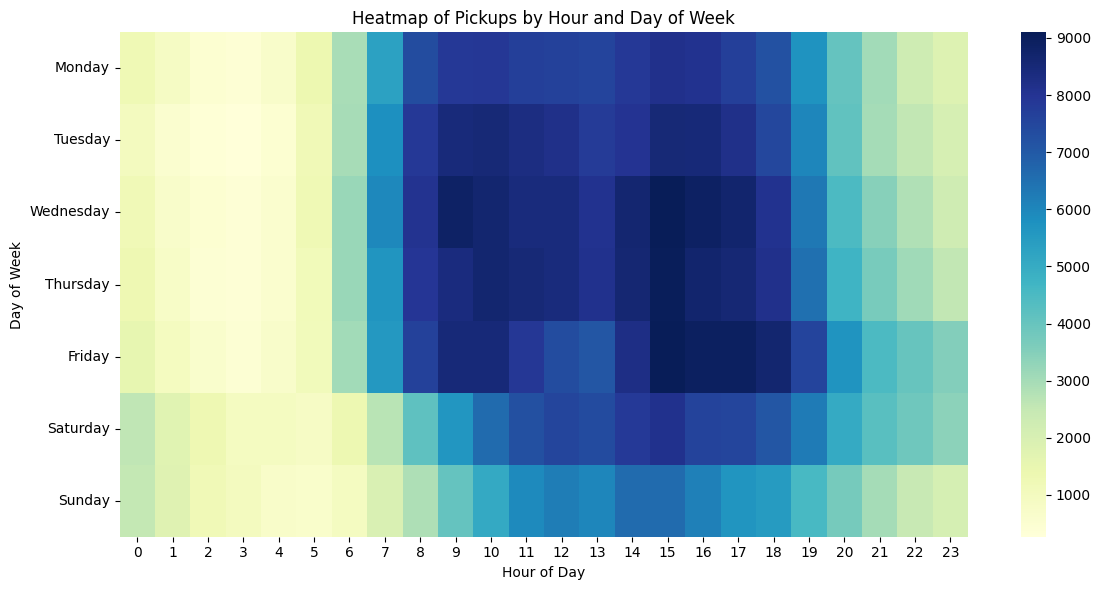

In [19]:
data['day'] = data['pickup_datetime'].dt.day_name()  # Get day of the week
data['hour'] = data['pickup_datetime'].dt.hour  # Get hour

# Create a pivot table with counts
heatmap_data = data.groupby(['day', 'hour']).size().unstack(fill_value=0)

# Reorder days of the week for better visualization
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar=True, fmt='d')
plt.title('Heatmap of Pickups by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

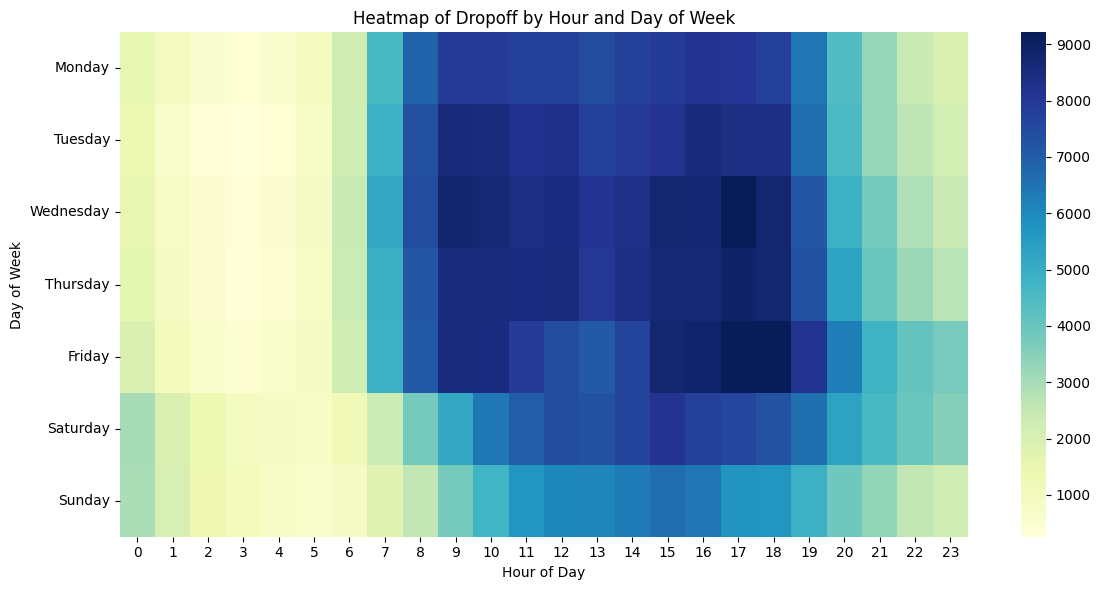

In [20]:
data['day2'] = data['dropoff_datetime'].dt.day_name()  # Get day of the week
data['hour2'] = data['dropoff_datetime'].dt.hour  # Get hour

# Create a pivot table with counts
heatmap_data = data.groupby(['day2', 'hour2']).size().unstack(fill_value=0)

# Reorder days of the week for better visualization
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar=True, fmt='d')
plt.title('Heatmap of Dropoff by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

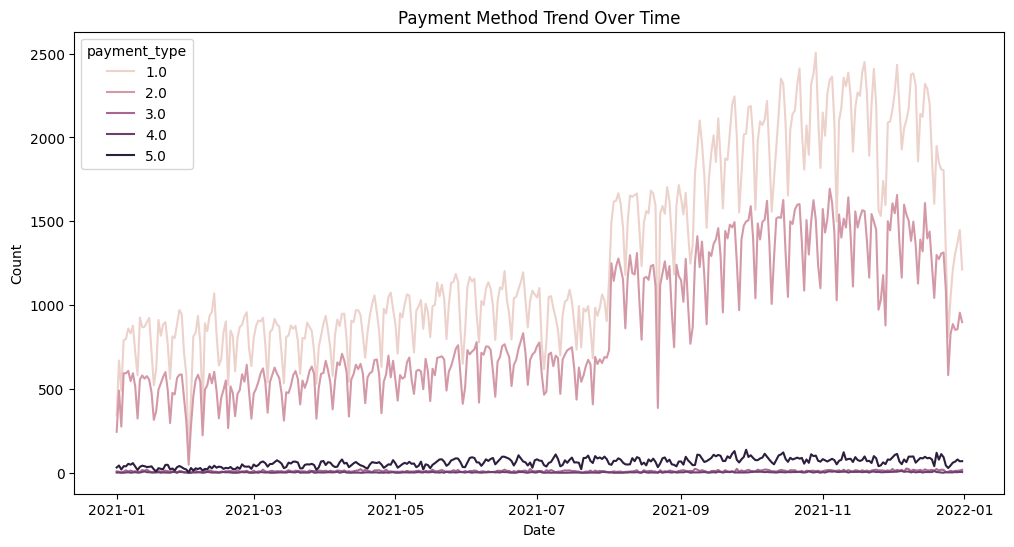

In [21]:
data['date'] = data['pickup_datetime'].dt.date
payment_trend = data.groupby(['date', 'payment_type']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=payment_trend, x='date', y='count', hue='payment_type')
plt.title('Payment Method Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

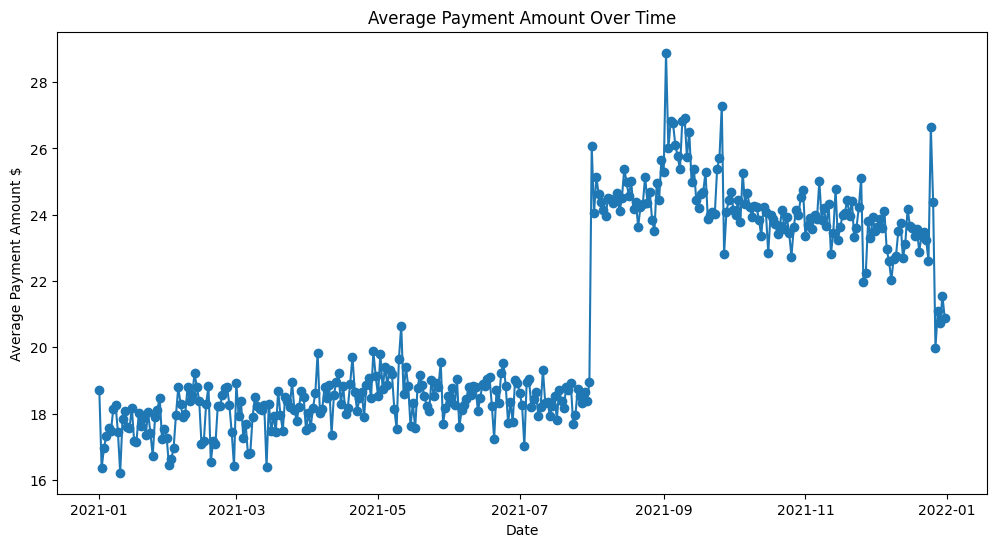

In [22]:
average_payment = data.groupby('date')['total_amount'].mean()
plt.figure(figsize=(12, 6))
average_payment.plot(kind='line', marker='o')
plt.title('Average Payment Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Average Payment Amount $')
plt.show()

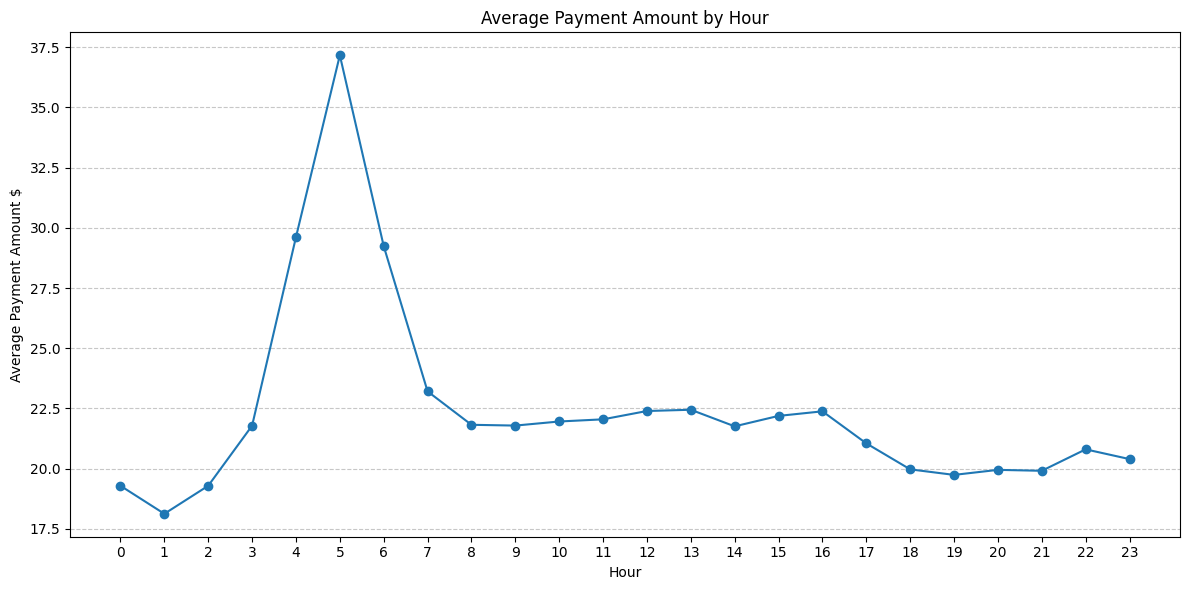

In [23]:
hour_amount = data.groupby('hour')['total_amount'].mean()
plt.figure(figsize=(12, 6))
hour_amount.plot(kind='line', marker='o')
plt.title('Average Payment Amount by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Payment Amount $')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

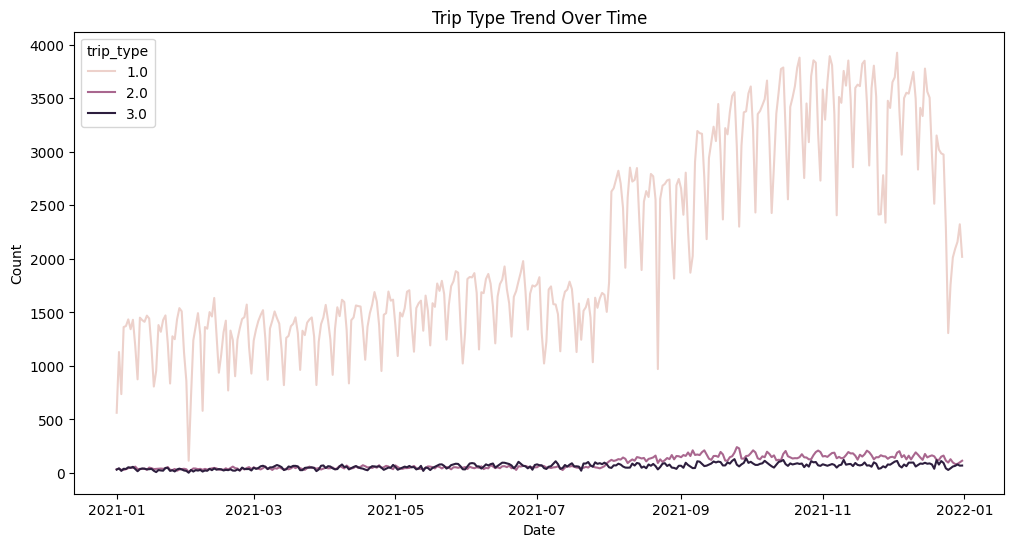

In [24]:
trip_trend = data.groupby(['date', 'trip_type']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=trip_trend, x='date', y='count', hue='trip_type')
plt.title('Trip Type Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

<Figure size 1200x600 with 0 Axes>

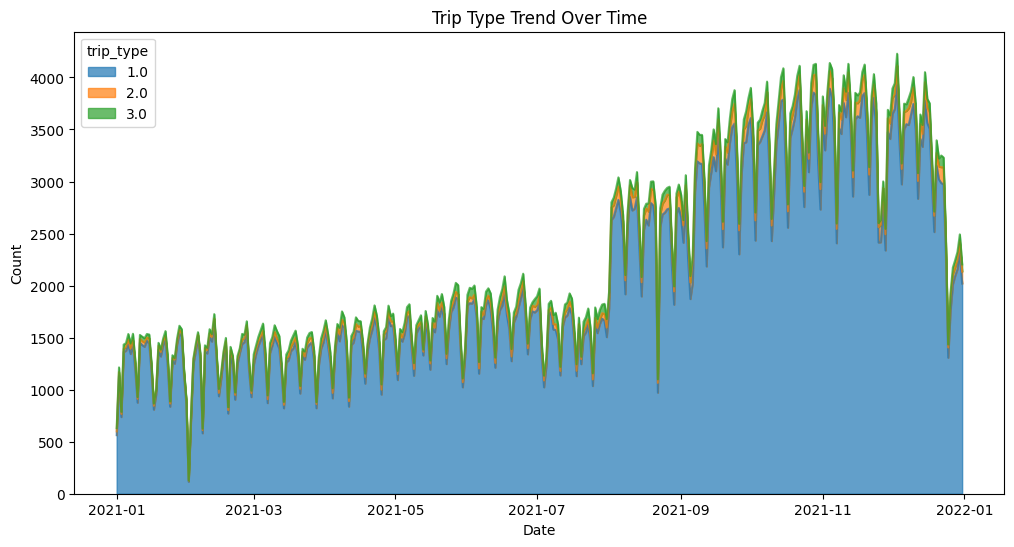

In [25]:
trip_trend = data.groupby(['date', 'trip_type']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
trip_trend.plot(kind='area', stacked=True, alpha=0.7, figsize=(12, 6))

plt.title('Trip Type Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Count')

plt.show()

In [26]:
boroug = pd.read_csv('Boroughs.csv')
boroug['Borough'].value_counts()

Borough
Manhattan        71
Queens           69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: count, dtype: int64

In [27]:
data = data.merge(boroug, left_on='PULocationID', right_on='LocationID', how='left')
data.rename(columns={'Borough': 'PUBorough'}, inplace=True)
data = data.merge(boroug, left_on='DOLocationID', right_on='LocationID', how='left')
data.rename(columns={'Borough': 'DOBorough'}, inplace=True)

In [28]:
data.head()

,VendorID,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,...,duration,day,hour,day2,hour2,date,LocationID_x,PUBorough,LocationID_y,DOBorough
0,2.0,43,151,1.0,1.01,0.00,0.0,6.80,2.0,1.0,...,3.933333,Friday,0,Friday,0,2021-01-01,43,Manhattan,151,Manhattan
1,2.0,166,239,1.0,2.53,2.81,0.0,16.86,1.0,1.0,...,8.750000,Friday,0,Friday,0,2021-01-01,166,Manhattan,239,Manhattan
2,2.0,41,42,1.0,1.12,1.00,0.0,8.30,1.0,1.0,...,5.966667,Friday,0,Friday,0,2021-01-01,41,Manhattan,42,Manhattan
3,2.0,265,265,3.0,0.00,0.00,0.0,-52.80,3.0,1.0,...,0.066667,Friday,0,Friday,0,2021-01-01,265,Manhattan,265,Manhattan
4,2.0,265,265,3.0,0.00,0.00,0.0,52.80,2.0,1.0,...,0.066667,Friday,0,Friday,0,2021-01-01,265,Manhattan,265,Manhattan


<Figure size 1200x600 with 0 Axes>

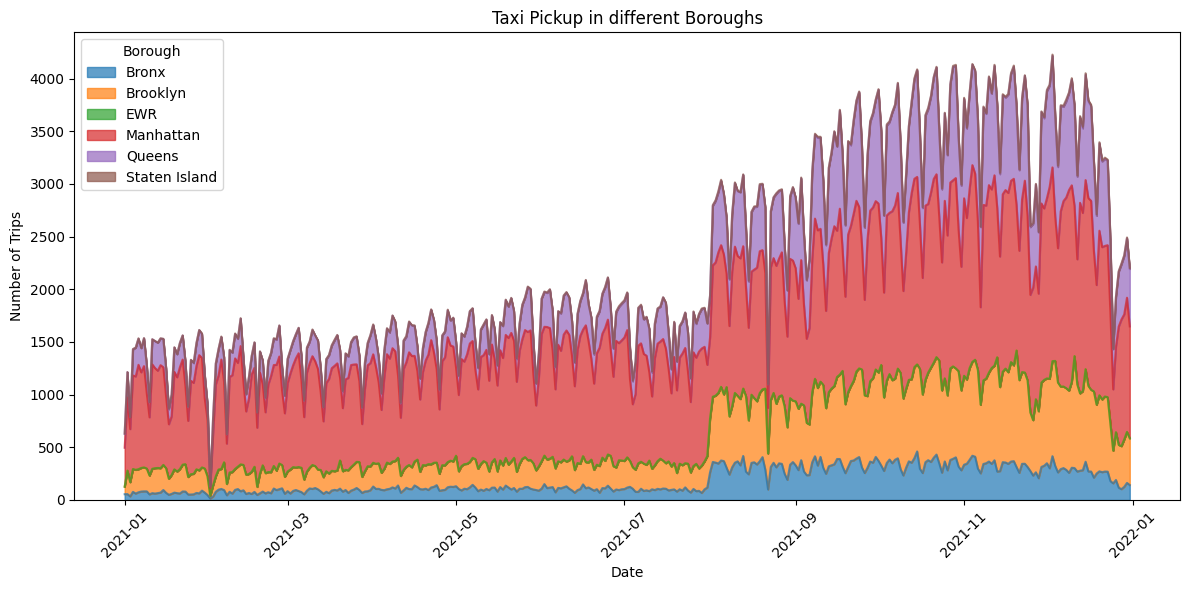

In [29]:
borough_trends = data.groupby(['date', 'PUBorough']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
borough_trends.plot(kind='area', stacked=True, alpha=0.7, figsize=(12, 6))
plt.title('Taxi Pickup in different Boroughs')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend(title='Borough', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

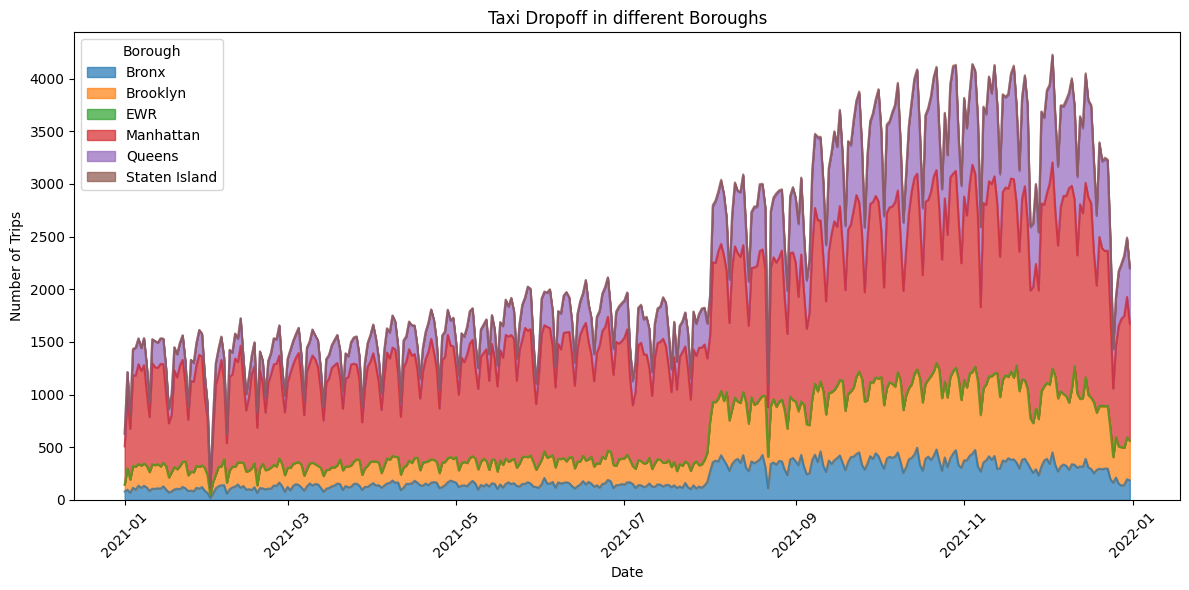

In [30]:
borough_trends = data.groupby(['date', 'DOBorough']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
borough_trends.plot(kind='area', stacked=True, alpha=0.7, figsize=(12, 6))
plt.title('Taxi Dropoff in different Boroughs')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend(title='Borough', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

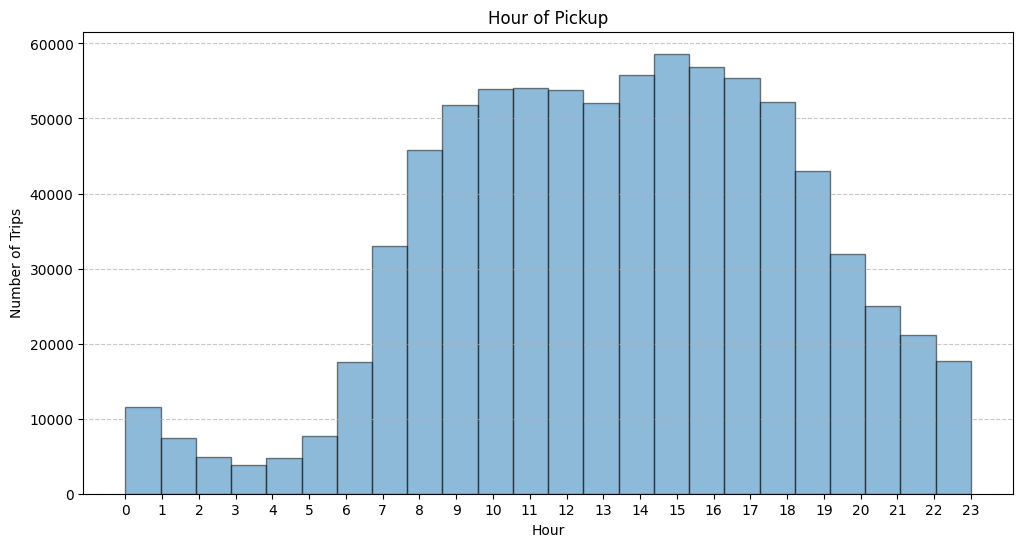

In [31]:
plt.figure(figsize=(12, 6))
plt.hist(data['hour'], bins=24, edgecolor='black', alpha=0.5)
plt.title('Hour of Pickup')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

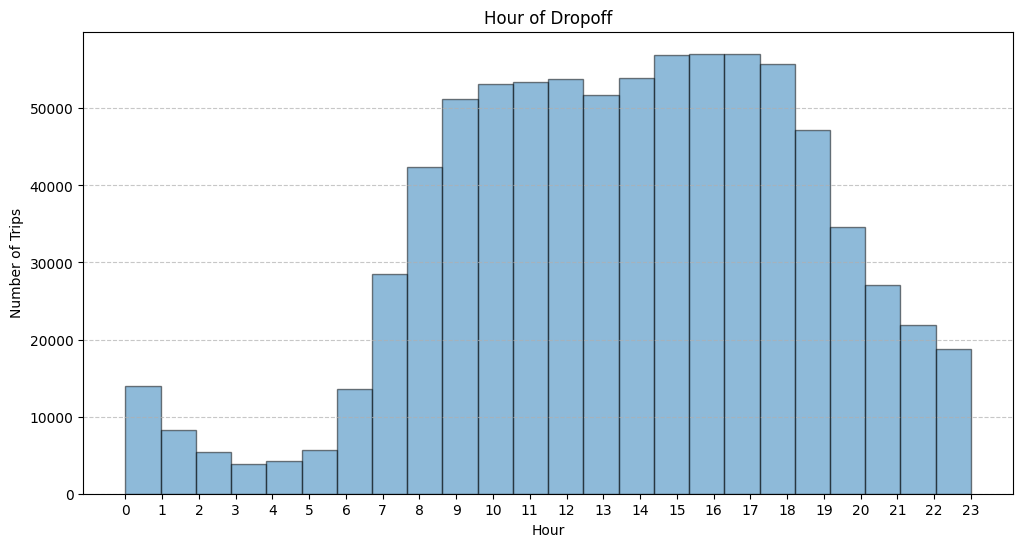

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(data['hour2'], bins=24, edgecolor='black', alpha=0.5)
plt.title('Hour of Dropoff')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
print('Average Hour of Pickup:' ,data['hour'].mean())
print('Peak Hour of Pickup:',data['hour'].mode()[0])

Average Hour of Pickup: 13.434462732275106
Peak Hour of Pickup: 15


In [34]:
data['z_score'] = (data['trip_distance'] - data['trip_distance'].mean()) / data['trip_distance'].std()
z_threshold = 3
data[abs(data['z_score']) <= z_threshold].count()

VendorID            818432
PULocationID        818432
DOLocationID        818432
passenger_count     818432
trip_distance       818432
tip_amount          818432
tolls_amount        818432
total_amount        818432
payment_type        818432
trip_type           818432
pickup_datetime     818432
dropoff_datetime    818432
duration            818432
day                 818432
hour                818432
day2                818432
hour2               818432
date                818432
LocationID_x        818432
PUBorough           818432
LocationID_y        818432
DOBorough           818432
z_score             818432
dtype: int64

In [35]:
data_cleaned = data[abs(data['z_score']) <= z_threshold].drop(columns=['z_score'])

In [36]:
data_cleaned.dtypes

VendorID                   float64
PULocationID                 int64
DOLocationID                 int64
passenger_count            float64
trip_distance              float64
tip_amount                 float64
tolls_amount               float64
total_amount               float64
payment_type               float64
trip_type                  float64
pickup_datetime     datetime64[ns]
dropoff_datetime    datetime64[ns]
duration                   float64
day                         object
hour                         int32
day2                        object
hour2                        int32
date                        object
LocationID_x                 int64
PUBorough                   object
LocationID_y                 int64
DOBorough                   object
dtype: object

In [37]:
data_cleaned['day'] = data['pickup_datetime'].dt.dayofweek
data_cleaned['day2'] = data['dropoff_datetime'].dt.dayofweek
data_cleaned = data_cleaned.drop(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'date', 'PUBorough', 'DOBorough', 'LocationID_x', 'LocationID_y'], axis=1)


In [38]:
data_cleaned = data_cleaned.drop(['PULocationID', 'DOLocationID'], axis=1)
data_cleaned.dtypes

passenger_count    float64
trip_distance      float64
tip_amount         float64
tolls_amount       float64
total_amount       float64
payment_type       float64
trip_type          float64
duration           float64
day                  int32
hour                 int32
day2                 int32
hour2                int32
dtype: object

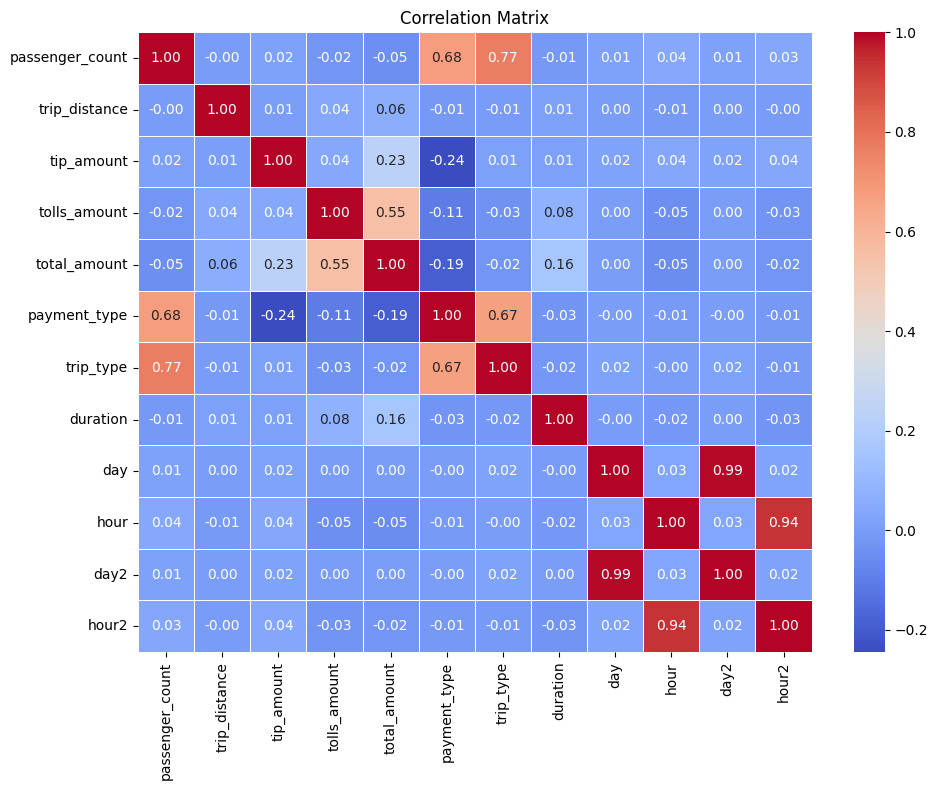

In [39]:
corr_matrix = data_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.4)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

day2 (dropoff day) with day (pickup day) and hour2 (dropoff hour) with hour (pickup hour) are highly correlated; so we delete day2 and hour2

In [40]:
data_cleaned = data_cleaned.drop(['day2', 'hour2'], axis=1)

In [41]:
def backward_elimination(data, target_col='total_amount', min_features=3, cv_folds=5):

    features = data.drop(columns=[target_col])
    target = data[target_col]
    model = LinearRegression()

    remaining_features = features.columns.tolist()

    while len(remaining_features) > min_features:
        scores = {}
        
        # Evaluate the effect of removing each feature
        for feature in remaining_features:
            candidate_features = [f for f in remaining_features if f != feature]
            cv_scores = cross_val_score(model, features[candidate_features], target, cv=cv_folds, scoring='r2')
            scores[feature] = np.mean(cv_scores)
        
        worst_feature = min(scores, key=scores.get)
        remaining_features.remove(worst_feature)

    return remaining_features

In [42]:
def forward_elimination(data, target_col='total_amount', min_features=5, cv_folds=5):

    features = data.drop(columns=[target_col])
    target = data[target_col]
    model = LinearRegression()

    remaining_features = features.columns.tolist()
    selected_features = []

    while len(selected_features) < min_features and len(remaining_features) > 0:
        scores = {}
        
        # Evaluate the effect of removing each feature
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            cv_scores = cross_val_score(model, features[candidate_features], target, cv=cv_folds, scoring='r2')
            scores[feature] = np.mean(cv_scores)
        
        best_feature = max(scores, key=scores.get)
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

In [43]:
def chi_square_feature_selection(data, target_col='total_amount', significance_level=0.05):
    
    X = data.drop(columns=[target_col])
    y = data[target_col]

    X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric where possible
    X = X.fillna(0)  # Replace NaNs with 0
    y = pd.to_numeric(y, errors='coerce').fillna(0)

    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    y_binned = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()

    chi_scores, p_values = chi2(X, y_binned)

    chi2_results = pd.DataFrame({
        'Feature': X.columns,
        'Chi-Square': chi_scores,
        'P-Value': p_values
    })

    selected_features = chi2_results[chi2_results['P-Value'] < significance_level]['Feature']

    return selected_features.tolist()


In [44]:
def random_forest_feature_selection(data, target_col='total_amount', n_estimators=100,n_f=5):
   
    X = data.drop(columns=[target_col])
    y = data[target_col]

    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X, y)

    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df)

    selected_features = feature_importance_df[0:n_f]

    return selected_features['Feature'].tolist()

In [45]:
data_cleaned = data_cleaned[(data_cleaned >= 0).all(axis=1)]

print('Backward:', backward_elimination(data_cleaned))
print('Forward:', forward_elimination(data_cleaned))
print('Chi_square:', chi_square_feature_selection(data_cleaned))
print('Random Forest:', random_forest_feature_selection(data_cleaned))

Backward: ['passenger_count', 'trip_type', 'day']
Forward: ['tolls_amount', 'tip_amount', 'duration', 'payment_type', 'trip_type']
Chi_square: ['passenger_count', 'trip_distance', 'tip_amount', 'tolls_amount', 'payment_type', 'trip_type', 'duration', 'hour']
           Feature  Importance
1    trip_distance    0.673254
6         duration    0.186945
2       tip_amount    0.051874
8             hour    0.027675
7              day    0.016054
5        trip_type    0.014831
4     payment_type    0.012865
3     tolls_amount    0.011545
0  passenger_count    0.004958
Random Forest: ['trip_distance', 'duration', 'tip_amount', 'hour', 'day']


In [46]:
data_cleaned['tip_paid'] = data_cleaned['tip_amount'].apply(lambda x: 1 if x > 0 else 0)

In [53]:
X = data_cleaned.drop(columns=['tip_paid', 'tip_amount'])  # Features
y = data_cleaned['tip_paid']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Decision Tree Results:
Accuracy: 0.9490662763136135
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     97451
           1       0.94      0.93      0.94     65820

    accuracy                           0.95    163271
   macro avg       0.95      0.95      0.95    163271
weighted avg       0.95      0.95      0.95    163271

Confusion Matrix:
 [[93438  4013]
 [ 4303 61517]]


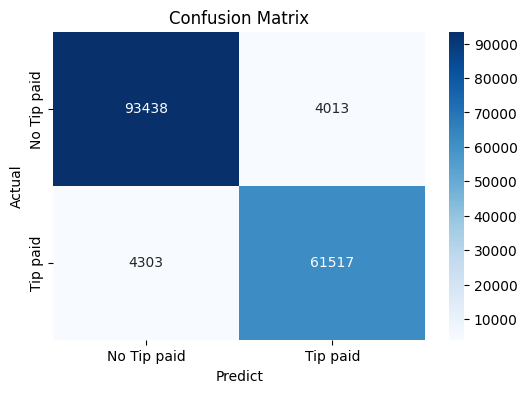

In [54]:
# 1. Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_predictions))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, dt_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['No Tip paid', 'Tip paid'], yticklabels=['No Tip paid', 'Tip paid'])
plt.title('Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()


XGBoost Results:
Accuracy: 0.9427454967508008
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     97451
           1       0.92      0.94      0.93     65820

    accuracy                           0.94    163271
   macro avg       0.94      0.94      0.94    163271
weighted avg       0.94      0.94      0.94    163271

Confusion Matrix:
 [[92146  5305]
 [ 4043 61777]]


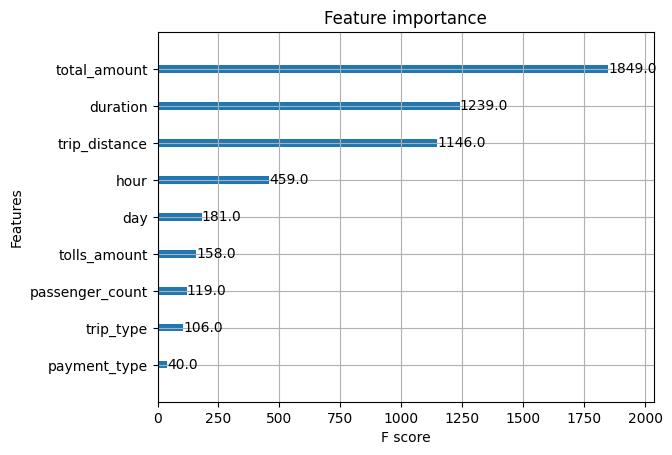

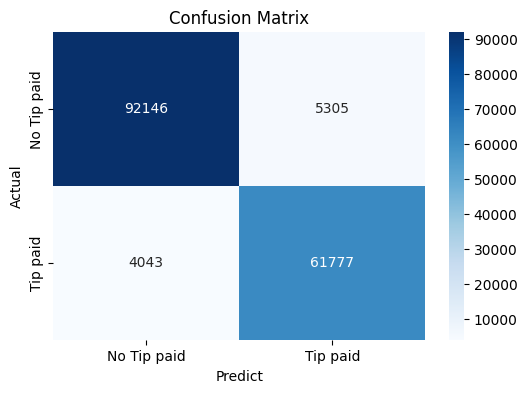

In [55]:
# 2. XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("\nXGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Classification Report:\n", classification_report(y_test, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))

xgb.plot_importance(xgb_model)
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['No Tip paid', 'Tip paid'], yticklabels=['No Tip paid', 'Tip paid'])
plt.title('Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()


Random Forest Results:
Accuracy: 0.9568753789711584
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     97451
           1       0.95      0.95      0.95     65820

    accuracy                           0.96    163271
   macro avg       0.96      0.96      0.96    163271
weighted avg       0.96      0.96      0.96    163271

Confusion Matrix:
 [[93884  3567]
 [ 3474 62346]]


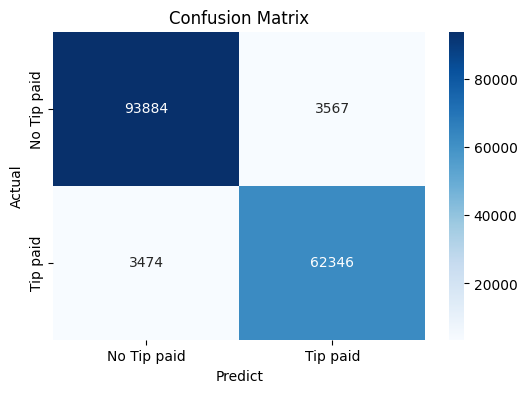

In [56]:
# 3. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['No Tip paid', 'Tip paid'], yticklabels=['No Tip paid', 'Tip paid'])
plt.title('Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()


Stacking Classifier Results:
Accuracy: 0.9532127567051099
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     97451
           1       0.94      0.94      0.94     65820

    accuracy                           0.95    163271
   macro avg       0.95      0.95      0.95    163271
weighted avg       0.95      0.95      0.95    163271

Confusion Matrix:
 [[93755  3696]
 [ 3943 61877]]


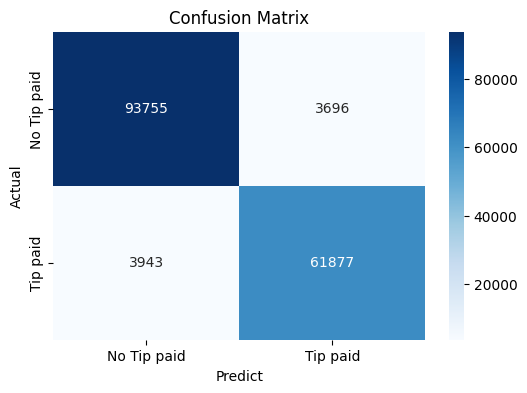

In [60]:
# base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('xgboost', xgb.XGBClassifier(random_state=42))
]

# meta model
meta_model = LogisticRegression()

# stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

print("\nStacking Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Tip paid', 'Tip paid'], yticklabels=['No Tip paid', 'Tip paid'])
plt.title('Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [86]:
# 1. Linear Regression Model
def LinearRegress (features , data=data_cleaned , target='total_amount'):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    linear_predictions = linear_model.predict(X_test)

    print("Linear Regression Results:")
    print("Coefficients:", linear_model.coef_)  # Coefficients of the model
    print("Intercept:", linear_model.intercept_)  # Intercept of the model
    print("MAE:", mean_absolute_error(y_test, linear_predictions))
    print("MSE:", mean_squared_error(y_test, linear_predictions))
    print("R2 Score:", r2_score(y_test, linear_predictions))


In [87]:
# 2. XGBoost Regressor
def XGBoostRegress (features , data=data_cleaned , target='total_amount'):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)

    print("\nXGBoost Results:")
    print("MAE:", mean_absolute_error(y_test, xgb_predictions))
    print("MSE:", mean_squared_error(y_test, xgb_predictions))
    print("R2 Score:", r2_score(y_test, xgb_predictions))

In [88]:
# 3. Random Forest Regressor
def RandomForestRegress (features , data=data_cleaned , target='total_amount'):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    print("\nRandom Forest Results:")
    print("MAE:", mean_absolute_error(y_test, rf_predictions))
    print("MSE:", mean_squared_error(y_test, rf_predictions))
    print("R2 Score:", r2_score(y_test, rf_predictions))

In [90]:
# 4. Gradient Boosting + Neural Network
def GradientBoostingplusNN (data=data_cleaned , target='total_amount'):
    X = data.drop(columns=[target])
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Gradient Boosting Model (XGBoost)
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Select important features using SelectFromModel
    selector = SelectFromModel(xgb_model, prefit=True, threshold="median")
    selected_features = X_train.columns[selector.get_support()]
    X_train_selected = pd.DataFrame(selector.transform(X_train), columns=selected_features)
    X_test_selected = pd.DataFrame(selector.transform(X_test), columns=selected_features)

    print("\nGradient Boosting + Neural Network Results:")
    print("Features selected:",selected_features)

    # Neural Network (MLPRegressor)
    nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    nn_model.fit(X_train_selected, y_train)


    # Predictions and evaluation
    y_pred = nn_model.predict(X_test_selected)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))

In [92]:
#important features sorted by randomforest
Features=['trip_distance','duration','tip_amount','hour','day','trip_type','tolls_amount']

for i in range(len(Features)):
    print('Features:', Features[0:i+1])
    print()
    LinearRegress(Features[0:i+1])
    XGBoostRegress(Features[0:i+1])
    print()
    print()

    # RandomForestRegress(Features[0:i+1]) becuase its take to much time

GradientBoostingplusNN()

Features: ['trip_distance']

Linear Regression Results:
Coefficients: [0.01299346]
Intercept: 21.81366483332048
MAE: 12.330350998133516
MSE: 312.9362271450974
R2 Score: 0.004302897511367254

XGBoost Results:
MAE: 4.620033451351137
MSE: 80.33337118629761
R2 Score: 0.7443961485282019


Features: ['trip_distance', 'duration']

Linear Regression Results:
Coefficients: [0.01254826 0.03345068]
Intercept: 20.997395295433964
MAE: 12.074063273071673
MSE: 305.11171240944867
R2 Score: 0.029198853859216722

XGBoost Results:
MAE: 3.7294862324357507
MSE: 64.91780942494285
R2 Score: 0.7934452161898332


Features: ['trip_distance', 'duration', 'tip_amount']

Linear Regression Results:
Coefficients: [0.01227632 0.03282777 1.57431962]
Intercept: 18.949059090733616
MAE: 11.692379576874009
MSE: 287.10221966403014
R2 Score: 0.08650126306730399

XGBoost Results:
MAE: 2.884374499056093
MSE: 52.244488181997575
R2 Score: 0.8337690526328966


Features: ['trip_distance', 'duration', 'tip_amount', 'hour']

Linear

c:\Users\Huawei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Huawei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Gradient Boosting + Neural Network Results:
Features selected: Index(['trip_distance', 'tolls_amount', 'payment_type', 'trip_type',
       'duration'],
      dtype='object')
MAE: 3.368005500872552
R2 Score: 0.8359696368854873
